In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation')
from utils.utils import setup_logging, get_config_from_yaml, process_config, print_config
from dataset.cityscapes import Cityscapes
from metrics.performance import SegmentationMetric
from utils.helper import val_plot
from patch.create import Patch
#from metrics.performance import SegmentationMetric


from pretrained_models.ICNet.icnet import ICNet
from pretrained_models.BisNetV1.model import BiSeNetV1
from pretrained_models.BisNetV2.model import BiSeNetV2
from pretrained_models.PIDNet.model import PIDNet, get_pred_model
import pickle
from copy import deepcopy
# from trainer.trainer import Trainer
# import torch
from tqdm import tqdm
config = get_config_from_yaml('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/configs/config.yaml')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
cityscape_train = Cityscapes(
          root = config.dataset.root,
          list_path = config.dataset.train,
          num_classes = config.dataset.num_classes,
          multi_scale = False,
          flip = False,
          ignore_label = config.train.ignore_label,
          base_size = config.train.base_size,
          crop_size = (config.train.height,config.train.width),
        )

train_dataloader = torch.utils.data.DataLoader(dataset=cityscape_train,
                                            batch_size=1,
                                            shuffle=True,
                                            num_workers=config.train.num_workers,
                                            pin_memory=config.train.pin_memory,
                                            drop_last=config.train.drop_last)

In [ ]:
## Getting the patch
pidnet_l_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/pidnet_l.p", "rb" ))

In [ ]:
## Getting model
model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretrained_models/PIDNet/PIDNet_L_Cityscapes_test.pt',map_location=device)
pidnet_l = get_pred_model(name = 'pidnet_l', num_classes = 19).to(device)
if 'state_dict' in model:
    model = model['state_dict']
model_dict = pidnet_l.state_dict()
model = {k[6:]: v for k, v in model.items() # k[6:] to start after model. in key names
                    if k[6:] in model_dict.keys()}

pidnet_l.load_state_dict(model)
pidnet_l.eval()
print('PIDNet Model loaded')

PIDNet Model loaded


<ipython-input-4-876f5f62ae63>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/pretr

In [ ]:
cityscapes_classes = {
    1: "Road",
    2: "Sidewalk",
    3: "Building",
    4: "Wall",
    5: "Fence",
    6: "Pole",
    7: "Traffic Light",
    8: "Traffic Sign",
    9: "Vegetation",
    10: "Terrain",
    11: "Sky",
    12: "Person",
    13: "Rider",
    14: "Car",
    15: "Truck",
    16: "Bus",
    17: "Train",
    18: "Motorcycle",
    19: "Bicycle",
    20: "Void"
}

<ipython-input-38-b1395e556eec>:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  col = plt.cm.get_cmap("tab20c", 20)


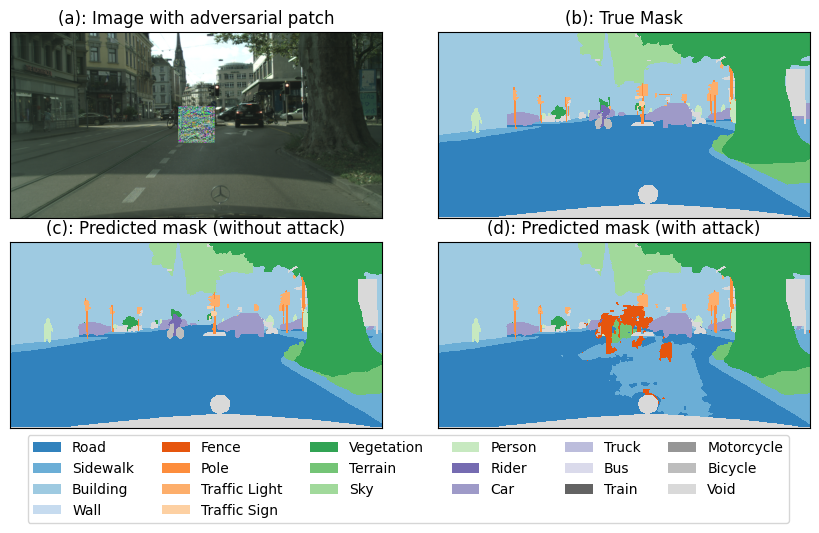

In [ ]:
model = pidnet_l
patch = pidnet_l_p[0]
mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
x = (2048 - 200)//2
y = (1024 - 200)//2
x_end = x + 200
y_end = y + 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for iter,batches in enumerate(train_dataloader):
  image_standard,label,_,_,_ = batches
  image = image_standard[0].permute(1,2,0)*std_standard+mean_standard
  label_patched = deepcopy(label)[0]

  image.permute(2,0,1)[:, y:y_end, x:x_end] = patch
  #label_patched[y:y_end, x:x_end] = 0
  label_patched[label_patched == 255] = 20

  ## Original Image
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(2, 2, 1)
  ax.imshow(image)
  ax.set_title('(a): Image with adversarial patch',size = 12)
  plt.xticks([])
  plt.yticks([])

  ## Original Patch
  ax = fig.add_subplot(2, 2, 2)
  ax.imshow(label_patched,cmap = 'tab20c', interpolation='nearest')
  ax.set_title('(b): True Mask',size = 12)
  #ax.add_patch(plt.Rectangle((x, y), 200, 200, linewidth=0, edgecolor='red', facecolor='k'))
  plt.xticks([])
  plt.yticks([])

  ## Prediction without patch
  image_standard = image_standard.to(device)
  outputs = pidnet_l(image_standard)
  size = label.shape
  output = F.interpolate(
                outputs[config.test.output_index_pidnet], size[-2:],
                mode='bilinear', align_corners=True
                        )
  output = output.data.cpu().numpy()
  output = np.argmax(output, axis=1)[0]
  ax = fig.add_subplot(2, 2, 3)
  output[label[0] == 255] = 20
  ax.imshow(output,cmap = 'tab20c', interpolation='nearest')
  ax.set_title('(c): Predicted mask (without attack)',size = 12)
  plt.xticks([])
  plt.yticks([])

  ## Prediction with patch
  image_standard[:,:, y:y_end, x:x_end] = patch
  image_standard = image_standard.to(device)
  outputs = model(image_standard)
  size = label.shape
  output = F.interpolate(
                outputs[config.test.output_index_pidnet], size[-2:],
                mode='bilinear', align_corners=True
                        )
  output = output.data.cpu().numpy()
  output = np.argmax(output, axis=1)[0]
  ax = fig.add_subplot(2, 2, 4)
  output[label[0] == 255] = 20
  ax.imshow(output,cmap = 'tab20c', interpolation='nearest')
  ax.set_title('(d): Predicted mask (with attack)',size = 12)
  plt.xticks([])
  plt.yticks([])

  #create legend
  #patches = [plt.Rectangle((0,0),1,1,fc=plt.cm.tab20c(i/19)) for i in range(19)]
  col = plt.cm.get_cmap("tab20c", 20)
  patches = [plt.Rectangle((0,0),1,1,fc=col(i/19)) for i in range(20)]


  labels = [cityscapes_classes.get(i+1) for i in range(20)] #handle potential missing keys

  plt.legend(patches, labels, bbox_to_anchor=(-0.08, -0.55), loc='lower center', ncol=6)

  #plt.tight_layout()
  fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15, hspace=0.1)
  plt.savefig("/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/figure1.pdf", format="pdf", dpi=300, bbox_inches="tight")
  plt.show()
  break


In [ ]:
## Fooling a transformer model

In [ ]:
segformer_p = pickle.load(open( "/content/drive/MyDrive/Colab Notebooks/1_Papers/3_Attack_generation/Experiments/segformer.p", "rb" ))
patch = segformer_p
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024").to(device)
segformer.eval()
print('Segformer loaded')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feat

Segformer loaded


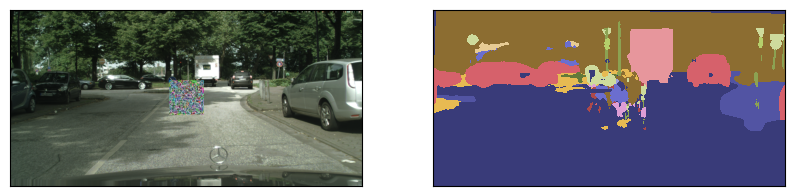

In [ ]:
model = segformer
patch = segformer_p.detach()
mean_standard = np.array([0.485, 0.456, 0.406],dtype = np.float32)
std_standard = np.array([0.229, 0.224, 0.225],dtype = np.float32)
x = (2048 - 200)//2
y = (1024 - 200)//2
x_end = x + 200
y_end = y + 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for iter,batches in enumerate(train_dataloader):
  image_standard,label,_,_,_ = batches
  image = image_standard[0].permute(1,2,0)*std_standard+mean_standard
  label_patched = deepcopy(label)[0]

  image.permute(2,0,1)[:, y:y_end, x:x_end] = patch
  #label_patched[y:y_end, x:x_end] = 0
  label_patched[label_patched == 255] = 0

  ## Original Image
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # ## Original Patch
  # ax = fig.add_subplot(2, 2, 2)
  # ax.imshow(label_patched[200:800,400:1600],cmap = 'tab20b', interpolation='nearest')
  # #ax.add_patch(plt.Rectangle((x, y), 200, 200, linewidth=0, edgecolor='red', facecolor='k'))
  # plt.xticks([])
  # plt.yticks([])

  # ## Prediction without patch
  # image_standard1 = image_standard[:,:,200:800,400:1600].to(device)
  # print(image_standard.shape)
  # outputs = model(image_standard1)
  # size = label.shape
  # output = F.interpolate(
  #               outputs.logits, size[-2:],
  #               mode='bilinear', align_corners=True
  #           )



  # output = output.data.cpu().numpy()
  # output = np.argmax(output, axis=1)[0]
  # ax = fig.add_subplot(2, 2, 3)
  # output[label[0] == 255] = 0
  # ax.imshow(output,cmap = 'tab20b', interpolation='nearest')
  # plt.xticks([])
  # plt.yticks([])

  ## Prediction with patch
  image_standard[:,:, y:y_end, x:x_end] = patch
  image_standard2 = image_standard[:,:,200:800,400:1600].to(device)
  outputs = model(image_standard2)
  size = label.shape
  output = F.interpolate(
                outputs.logits, size[-2:],
                mode='bilinear', align_corners=True
                        )
  output = output.data.cpu().numpy()
  output = np.argmax(output, axis=1)[0]
  ax = fig.add_subplot(1, 2, 2)
  output[label[0] == 255] = 0
  ax.imshow(output,cmap = 'tab20b', interpolation='nearest')
  plt.xticks([])
  plt.yticks([])
  plt.show()

  break



In [ ]:
del model
gc.collect()
torch.cuda.empty_cache()
